# Optimized Model
This model does not show under- or overfitting and performs well on both, training and testing data. Afterwards, a brief description on how to tackle the challenges of an optimal model complexity. 

To address underfitting, one approach is to increase the complexity of the model by adding more layers or increasing the number of filters in each layer. To address overfitting, we can try several approaches. One approach is to simplify the model by removing some layers or decreasing the number of filters in each layer. Another approach is to use less epochs for example.




Adding dropout or weight decay can help to address both of the above mentioned issues. We can also try adjusting the hyperparameters such as learning rate, batch size, or number of epochs.

## GPU Acceleration
We found out that training a model on images can be a very time consuming task, especially if many images are involved. Randomly we stumbled upon an article that stated about "GPU Acceleration" which sounded pretty interesting. Afterwards, we read a bit about the topic and found out that it is possible on our Apple M1 Pro / M2 Pro chips. After a lot of trial and error we ended up using the tensorflow-macos and tensorflow-metal packages but with specific versions because the newest versions did not work. With the both packages installed correctly, both the CPU and GPU are being used for training. The CPU on the M2 Pro chip has 12 cores and a 19 core GPU. The total of 31 cores over 12 cores already indicates that usage of the GPU would lead to massive performance improvements. The following image shows the CPU and GPU usage during training of the optimized model:
![GPU Acceleration](gpu-acceleration.png "GPU Acceleration")

When we were utilizing the CPU only training took ~100s per epoch for the overfitting model (~11'000'000 trainable parameters). After enabling GPU acceleration we came down to astonishing ~10s per epoch. This factor of 10 improvement was even more than we hoped and enabled us to test more parameters because training took about 2 minutes instead of the usual 20 minutes.

## Dataset Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14195712765706535620
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 5881510812272863760
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: 


2023-03-13 13:07:50.354559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 13:07:50.354841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Data Augmentation
Data Augmentation has proven to be a useful tool for model generalization. We've compared the same model with and without data augmentation and the results show that the model without data augmentation tends to overfit while the model with data augmentation doesn't:
![Data Augmentation Result](comparison-data-agumentation.jpg "Data Augmentation Result")

During this project we've also encountered some downsides of data augmentation. One apparent downside is that it drastically slows down the training because the images are being preprocessed. Another downside is that data augmentation somehow fails in combination with GridSearchCV which we've encountered only accidentially and already thought that our model is the problem why the learning curve converged in the second step at an accuary of 0.2.

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

img_size = 150
batch_size = 128
seed = 31

train_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    './dataset/seg_test/seg_test',
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2666 files belonging to 5 classes.
Using 2133 files for training.


2023-03-13 13:07:56.036865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 13:07:56.036908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2666 files belonging to 5 classes.
Using 533 files for validation.
Found 2499 files belonging to 5 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, Rescaling, RandomFlip

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

2023-03-12 11:58:08.394571: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


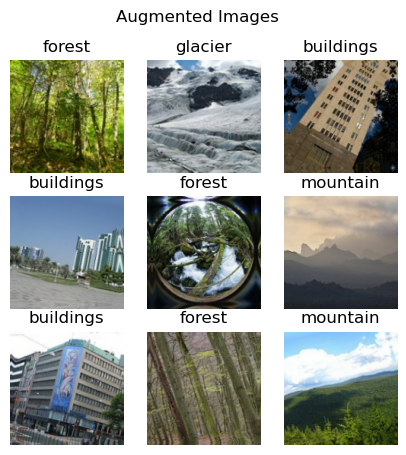

In [5]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']
def plot_images(title, augment = False):
  plt.figure(figsize=(5, 5))
  plt.suptitle(title)
  for images, labels in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(images) if augment else images
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plot_images("Augmented Images", augment=True)

## Building the Model
As a baseline we used the same model as the overfitting one but we add some extras to reduce the overfitting behavior.

### Regularization
Regularization is used to reduce the impact impact of the weights. The weights then end up having less impact on the loss function which determines the error between the actual label and predicted label. This reduces complexity of the model and therefore reduces overfitting. We are adding regularization only to those layers which have the largest number of parameters according to the model summary. We are using L2 (Ridge) regularization since it predetermined from the task. We are adding L2 mainly to the layers that add the most parameters to the CNN.

Dropout Layers: The benefit of using dropout is no node in the network will be assigned with high parameter values, as a a result the parameter values will be dispersed and the output of the current layer will not depend on a single node.
E.g. Dropout(0.2) drops the input layers at a probability of 0.2. Dropout is applied per batch size, so the parameters get tuned for a full batch size with missing input parameters which results in lower generalization errors. 

### Generalization
To improve generalization of the model, data augmentation is a useful tool. With data augmentation we can add artificial effects to the images such as flipping and rotating. Through these effects, the images always appear differently each time they appear in the training step and therefore the CNN doesn't adapt to the exact images but rather learns about the relative features inside of an image.

### Optimizer
For the optimized model we chose Adam over the competitors because it is the most common among SGD. We tried out SGD but it performed very poorly compared to Adam which might be due to insufficient configuration of the learning rate. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Its default implementation already provides a form of annealed learning, beta_1=0.9 for the first-order moment and beta_2=0.999 for the second-order moment. 

### Activation Function
The [following article](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365) states that ReLU is the overall the best suited activation function so based on this we decided to use ReLU for our optimized model.

### Batch Size
The batch size defines how many samples (images here) run through the Neural Network before the weights get adapted. It is recommended to use mini batches to update the Neural Network multiple times during an epoch. We've tried out differnt batch sizes with the same seed on the image generator TODO

## Layers
### First Layer
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network because in general, the input values should be small. Therefore we use the Rescaling layer as a normalization layer. 

### Dropout
With Cross-Validation we've tried out different dropout params (0.2, 0.3, 0.4) for the layer before the dense layers. The results are pretty similar but the 0.3 dropout seems to be more stable at the end of 30 epochs so we used this parameter for the model. The steep spikes of accuracy in the first few epochs are expected because due to dropout, some parameters are missing everytime and the model improves a lot over a short period of time because other parameters are being dropped out at every epoch. 
![Last Layer Dropout](history-data/dropout-param-5fold-cv.png "Last Layer Dropout")

### Last Layer
For the last layer we tried out 512, 1024 and 2048 trainable parameters and the Cross-Validation result was that the accuracy and loss were not drastically affected but the network with 2048 parameters in the last layer was much more stable than the others. Based on this fact, we sticked with using 2048 parameters in the last layer.
![CV Last Layer](history-data/last-layer-param-5fold-cv.png "CV Last Layer")

### Loss Function
Because we use the SoftMax activation function as the output of the last Dense Layer, we get normalized probabilites, [0, 1]. The SparseCategoricalCrossentry function's from_logits=True would expect Logits which are in the range of [-inf, +inf] and therefore, we use from_logits=False.¨

As the optimizer, we also tried out SGD with annealed learning but in the course of 20 epochs we reached poorer results than with adam.

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

def create_model(l2_param=0.001, last_dropout_param=0.3, last_layer_param=512, augment=True):
    model = Sequential()

    if augment:
        model.add(data_augmentation)
        model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size, 3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    if last_layer_param != 0:
        model.add(Conv2D(last_layer_param, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
        model.add(MaxPooling2D())

    model.add(Dropout(last_dropout_param))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(
       optimizer = 'adam', 
       loss=SparseCategoricalCrossentropy(from_logits=False), 
       metrics=['accuracy']
    )

    return model

## Cross Validation for Parameter Optimization
For k-fold Cross Validation parameter optimization we are using a sklearn's KFold method paired with a custom functionality to fit the model with different parameter values. We tried to use GridSearchCV (as we did in the AI Foundation course) but we first thought that the model parameters (such as the regularization parameter of the 2nd Conv2D layer) are not accessible from the `param_grid` that is passed to GridSearchCV (which we later found out is not the case). We then came up with a custom KFold Cross Validation approach which is fully flexible and uses if-else statements in the model creation step. With this Cross Validation implementation we've tuned parameters such as the l2 regularization paramter, the number of trainable parameters in the last Conv2D layer or the percentage of dropout before the dense layers.

The following image visualizes the results of the l2 regularization parameter. We tested for the values 0.01, 0.001 and 0.0001 and ran a 5-fold Cross Validation with 10 epochs for each value. The regularizer is being used in three Conv2D layers of the model. As from the diagram below it is apparent that the accuracy improved the smaller the l2 regularization parameter became and, therefore, we decided to use l2=0.0001. 
![l2 Parameter Optimization](history-data/l2-param-5fold-cv.png "l2 Parameter Optimization")

### Development of the kFold CV Functionality
The part of splitting the full dataset into testing and validation data by the indices obtained by the KFold split was pretty tricky. We've encountered that it is not always convenient and easy to handle the tensorflow data. Especially without experience of the huge framework it was difficult to find information about splitting a dataset and we ended up trying out numerous ways. In the end we consulted ChatGPT which lead us in the right direction. One problem we've had is that the generated filtering functionality did not work directly and after reading the documentation of the filter method, it was not clear which parameters are being passed to this function. Also, it is surprising that tensorflow doesn't seem to have an out-of-the-box solution for such a dataset split. In the end we found out how the methods works and the implementation was successful.

The current solution is not optimal because the `.filter(... reduce_any(...))` is not performant and massively slows down the training which would be important to improve in a real project. Nevertheless, the implementation works and enabled us to make sophisticated comparisons of the model parameters. 

During the usage of the intense training functionality of KFold Cross Validation we encountered a problem using tensorflow-metal with GPU acceleration. The problem is that the python process hangs up after approximately the 8-th fold of a 10 epoch training process. This was very inconvenient because we were not able to perform the parameter optimization in one step and needed to temporarily store the results for each parameter which we made by saving the results in a JSON file. Luckily, we were able to perform the 5-fold Cross Validation of at least one parameter before the process hung up. The issue of this phenomenon is known but does not seem to be fixed yet, as can be seen [here]( https://developer.apple.com/forums/thread/713944). 

In [ ]:
import itertools
from sklearn.model_selection import KFold
import tensorflow as tf
import json

param_grid=dict(
    # last_layer_param=[512, 1024, 2048]
    l2_param=[0.01, 0.001, 0.0001],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
epochs = 10
folds = 5

keys = list(param_grid.keys())
params = list(param_grid.get(x) for x in keys)
param_permutations = list(itertools.product(*params))

model_history = dict()

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)

images = np.concatenate([x for x, y in dataset], axis=0)
labels = np.concatenate([y for x, y in dataset], axis=0)

kfold = KFold(n_splits=folds, shuffle=True)

for perm in param_permutations:
    model_args = dict()
    for index in range(len(params)):
        key = keys[index]
        value = perm[index]
        model_args[key] = value

    # Set title according to the params for later visualization
    title = ", ".join(list((key + ": " + str(model_args[key])) for key in model_args.keys()))
    
    print("CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS: " + title)
    model_history[title] = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(images)):
        print(f'Fold {fold+1}/{folds}, (params={title})')

        train_images, train_labels = images[train_indices], labels[train_indices]
        val_images, val_labels = images[val_indices], labels[val_indices]

        train_dataset = dataset.unbatch().filter(lambda img, label: tf.reduce_any(tf.equal(label, train_labels))).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        val_dataset = dataset.unbatch().filter(lambda img, label: tf.reduce_any(tf.equal(label, val_labels))).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

        model = create_model(**model_args)
        
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs
        )

        # Evaluate the model on the validation dataset for this fold
        loss, acc = model.evaluate(test_ds)
        print(f'Validation accuracy: {acc:.3f}\n')

        # Use title as key for easy usage
        model_history[title].append(dict(fold=fold, loss=loss, acc=acc))

    with open(f'model-history-{title}.json', 'w') as f:
        json.dump(model_history, f)

### Visualizaton of the Parameter Performance

In [ ]:
model_history = {
    "last_layer_param: 512": [{"fold": 0, "loss": 0.9580041766166687, "acc": 0.6450580358505249}, {"fold": 1, "loss": 0.8243932127952576, "acc": 0.685874342918396}, {"fold": 2, "loss": 1.3444817066192627, "acc": 0.5246098637580872}, {"fold": 3, "loss": 0.9893543124198914, "acc": 0.6194477677345276}, {"fold": 4, "loss": 0.8950880169868469, "acc": 0.6618647575378418}],
    "last_layer_param: 1024": [{"fold": 0, "loss": 1.002255916595459, "acc": 0.6302521228790283}, {"fold": 1, "loss": 1.0927249193191528, "acc": 0.5918367505073547}, {"fold": 2, "loss": 1.0004750490188599, "acc": 0.6314525604248047}, {"fold": 3, "loss": 0.9172393679618835, "acc": 0.6574629545211792}, {"fold": 4, "loss": 1.024383306503296, "acc": 0.6054421663284302}],
    "last_layer_param: 2048": [{"fold": 0, "loss": 1.1013964414596558, "acc": 0.5674269795417786}, {"fold": 1, "loss": 0.9457604289054871, "acc": 0.6214485764503479}, {"fold": 2, "loss": 1.1457700729370117, "acc": 0.5774309635162354}, {"fold": 3, "loss": 0.8856483101844788, "acc": 0.6426570415496826}, {"fold": 4, "loss": 0.9397972822189331, "acc": 0.6210483908653259}]
}
accuracies = dict()
print(model_history)
losses = dict()
for key in model_history.keys():
    accuracies[key] = []
    losses[key] = []
    for entry in model_history[key]:
        losses[key].append(entry["loss"])
        accuracies[key].append(entry["acc"])

fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].set_title("Accuracies")
ax[0].boxplot(accuracies.values())
ax[0].set_xticklabels(accuracies.keys(), rotation=45)
ax[1].set_title("Losses")
ax[1].boxplot(losses.values())
ax[1].set_xticklabels(losses.keys(), rotation=45)

fig.set_figheight(15)
fig.set_figwidth(15)

### Update with GridSearchCV
Apparently the first believe that the model parameters can't be optimized using GridSearchCV was a misperception because `model.get_params()` just did not output the expected parameters... This is especially annoying because much time has been spent with the custom Cross Validation implementation. Because of the huge effort, we left the above implementation but still provide a version using GridSearchCV which is way more elegant and outperforms the custom implementation by large. 

In [8]:
def create_model_SGD(last_layer_param, augment=True):
    model = Sequential()
    if augment:
        model.add(data_augmentation)
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(last_layer_param, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(BatchNormalization())
    model.add(Dense(last_layer_param, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(5, activation = 'softmax'))
    
    # compilation of the model
    
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer='SGD', metrics=['accuracy'])
    
    return model

In [11]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)

images = np.concatenate([x for x, y in dataset], axis=0)
labels = np.concatenate([y for x, y in dataset], axis=0)

param_grid=dict(
    model__last_layer_param=[256, 512, 1024],
    model__augment=[False]
    # model__l2_param=[0.001, 0.0001],
    # model__last_dropout_param=[0.2, 0.3, 0.4]
)

model = KerasClassifier(model=create_model)

print(model.get_params())

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid_result = grid.fit(images, labels, epochs=20)

Found 2666 files belonging to 5 classes.
{'model': <function create_model_SGD at 0x3d98edbd0>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': None, 'validation_batch_size': None, 'verbose': 1, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 1, 'class_weight': None}
Epoch 1/20


2023-03-12 12:00:02.983909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 5s 63ms/step - loss: 2.0643 - accuracy: 0.2036
Epoch 2/20
67/67 [==============================] - 4s 60ms/step - loss: 1.7027 - accuracy: 0.2842
Epoch 3/20
67/67 [==============================] - 4s 60ms/step - loss: 1.4426 - accuracy: 0.4006
Epoch 4/20
17/67 [======>.......................] - ETA: 3s - loss: 1.2757 - accuracy: 0.4982

KeyboardInterrupt: 

In [14]:
grid.cv_results_

{'mean_fit_time': array([11.93981638, 11.58147006, 12.1076292 ]),
 'std_fit_time': array([1.74327387, 0.35700297, 0.51286515]),
 'mean_score_time': array([0.52733231, 0.61137881, 0.59718003]),
 'std_score_time': array([0.07365053, 0.06901077, 0.06126241]),
 'param_model__l2_param': masked_array(data=[0.01, 0.001, 0.0001],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__l2_param': 0.01},
  {'model__l2_param': 0.001},
  {'model__l2_param': 0.0001}],
 'split0_test_score': array([0.21910112, 0.21910112, 0.21910112]),
 'split1_test_score': array([0.22138837, 0.22138837, 0.22138837]),
 'split2_test_score': array([0.22138837, 0.22138837, 0.22138837]),
 'split3_test_score': array([0.22138837, 0.22138837, 0.22138837]),
 'split4_test_score': array([0.22138837, 0.22138837, 0.22138837]),
 'mean_test_score': array([0.22093092, 0.22093092, 0.22093092]),
 'std_test_score': array([0.0009149, 0.0009149, 0.0009149]),
 'rank_test_score': 

In [7]:
from tensorcross.model_selection import GridSearchCV

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)
param_grid=dict(
    # last_layer_param=[256, 512, 1024],
    l2_param=[0.001, 0.0001],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
grid_search_cv = GridSearchCV(
    model_fn=create_model,
    param_grid=param_grid,
    n_folds=2,
)

grid_search_cv.fit(
    dataset=dataset,
    epochs=20,
)

Found 2666 files belonging to 5 classes.
Running Comb: 0
Running Fold: 0
Epoch 1/20


2023-03-13 13:10:41.774894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 7.6220 - accuracy: 0.3434

2023-03-13 13:10:44.756989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 4s 83ms/step - loss: 7.6220 - accuracy: 0.3434 - val_loss: 2.4455 - val_accuracy: 0.4368
Epoch 2/20
42/42 [==============================] - 3s 73ms/step - loss: 2.3694 - accuracy: 0.4985 - val_loss: 2.2573 - val_accuracy: 0.5647
Epoch 3/20
42/42 [==============================] - 3s 70ms/step - loss: 2.2190 - accuracy: 0.5227 - val_loss: 2.0313 - val_accuracy: 0.5885
Epoch 4/20
42/42 [==============================] - 3s 70ms/step - loss: 2.0638 - accuracy: 0.5628 - val_loss: 1.9931 - val_accuracy: 0.5744
Epoch 5/20
42/42 [==============================] - 3s 70ms/step - loss: 1.8733 - accuracy: 0.6120 - val_loss: 1.7018 - val_accuracy: 0.6585
Epoch 6/20
42/42 [==============================] - 3s 71ms/step - loss: 1.7051 - accuracy: 0.6445 - val_loss: 1.7641 - val_accuracy: 0.6101
Epoch 7/20
42/42 [==============================] - 3s 71ms/step - loss: 1.6437 - accuracy: 0.6657 - val_loss: 1.5766 - val_accuracy: 0.6801
Epoch 8/20
42/42 [======

2023-03-13 13:11:43.975485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 7.0161 - accuracy: 0.3199

2023-03-13 13:11:46.688475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 4s 79ms/step - loss: 7.0161 - accuracy: 0.3199 - val_loss: 2.5377 - val_accuracy: 0.4017
Epoch 2/20
42/42 [==============================] - 3s 73ms/step - loss: 2.3597 - accuracy: 0.4888 - val_loss: 2.6253 - val_accuracy: 0.3903
Epoch 3/20
42/42 [==============================] - 3s 74ms/step - loss: 2.2169 - accuracy: 0.5298 - val_loss: 2.1942 - val_accuracy: 0.5166
Epoch 4/20
42/42 [==============================] - 3s 72ms/step - loss: 1.9891 - accuracy: 0.6012 - val_loss: 1.8585 - val_accuracy: 0.6362
Epoch 5/20
42/42 [==============================] - 3s 71ms/step - loss: 1.8531 - accuracy: 0.6250 - val_loss: 1.7804 - val_accuracy: 0.6475
Epoch 6/20
42/42 [==============================] - 3s 74ms/step - loss: 1.6700 - accuracy: 0.6786 - val_loss: 1.7996 - val_accuracy: 0.6566
Epoch 7/20
42/42 [==============================] - 3s 72ms/step - loss: 1.6515 - accuracy: 0.6949 - val_loss: 1.7156 - val_accuracy: 0.6702
Epoch 8/20
42/42 [======

2023-03-13 13:12:46.881072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 7.9981 - accuracy: 0.2814

2023-03-13 13:12:49.985025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 4s 87ms/step - loss: 7.9981 - accuracy: 0.2814 - val_loss: 2.7450 - val_accuracy: 0.4918
Epoch 2/20
42/42 [==============================] - 3s 72ms/step - loss: 2.6207 - accuracy: 0.5121 - val_loss: 2.5477 - val_accuracy: 0.5007
Epoch 3/20
42/42 [==============================] - 3s 73ms/step - loss: 2.4053 - accuracy: 0.5545 - val_loss: 2.2872 - val_accuracy: 0.5565
Epoch 4/20
42/42 [==============================] - 3s 73ms/step - loss: 2.2291 - accuracy: 0.5817 - val_loss: 2.1000 - val_accuracy: 0.6250
Epoch 5/20
42/42 [==============================] - 3s 73ms/step - loss: 2.0551 - accuracy: 0.6210 - val_loss: 1.9975 - val_accuracy: 0.6034
Epoch 6/20
42/42 [==============================] - 3s 73ms/step - loss: 1.9485 - accuracy: 0.6369 - val_loss: 1.9129 - val_accuracy: 0.6324
Epoch 7/20
42/42 [==============================] - 3s 72ms/step - loss: 1.8271 - accuracy: 0.6710 - val_loss: 1.7572 - val_accuracy: 0.6823
Epoch 8/20
42/42 [======

2023-03-13 13:13:51.014631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 5.8891 - accuracy: 0.2478

2023-03-13 13:13:53.825770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 4s 83ms/step - loss: 5.8891 - accuracy: 0.2478 - val_loss: 3.0880 - val_accuracy: 0.0938
Epoch 2/20
42/42 [==============================] - 3s 75ms/step - loss: 2.7909 - accuracy: 0.4256 - val_loss: 2.5460 - val_accuracy: 0.5166
Epoch 3/20
42/42 [==============================] - 3s 75ms/step - loss: 2.4751 - accuracy: 0.5082 - val_loss: 2.5110 - val_accuracy: 0.4516
Epoch 4/20
42/42 [==============================] - 3s 77ms/step - loss: 2.2905 - accuracy: 0.5298 - val_loss: 2.0885 - val_accuracy: 0.6392
Epoch 5/20
42/42 [==============================] - 3s 75ms/step - loss: 2.1457 - accuracy: 0.5685 - val_loss: 2.1593 - val_accuracy: 0.5749
Epoch 6/20
42/42 [==============================] - 3s 76ms/step - loss: 1.9432 - accuracy: 0.6235 - val_loss: 1.8929 - val_accuracy: 0.6460
Epoch 7/20
42/42 [==============================] - 3s 74ms/step - loss: 1.8348 - accuracy: 0.6324 - val_loss: 1.7612 - val_accuracy: 0.6853
Epoch 8/20
42/42 [======

2023-03-13 13:14:55.669362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 10.2136 - accuracy: 0.2731

2023-03-13 13:14:59.290574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 5s 96ms/step - loss: 10.2136 - accuracy: 0.2731 - val_loss: 3.1063 - val_accuracy: 0.4576
Epoch 2/20
42/42 [==============================] - 3s 79ms/step - loss: 3.0001 - accuracy: 0.4372 - val_loss: 2.7976 - val_accuracy: 0.5000
Epoch 3/20
42/42 [==============================] - 3s 78ms/step - loss: 2.6455 - accuracy: 0.5287 - val_loss: 2.4677 - val_accuracy: 0.6131
Epoch 4/20
42/42 [==============================] - 3s 78ms/step - loss: 2.5160 - accuracy: 0.5651 - val_loss: 2.3537 - val_accuracy: 0.5908
Epoch 5/20
42/42 [==============================] - 3s 78ms/step - loss: 2.2931 - accuracy: 0.6029 - val_loss: 2.1941 - val_accuracy: 0.6064
Epoch 6/20
42/42 [==============================] - 3s 77ms/step - loss: 2.1554 - accuracy: 0.6331 - val_loss: 2.0454 - val_accuracy: 0.6585
Epoch 7/20
42/42 [==============================] - 3s 78ms/step - loss: 2.0378 - accuracy: 0.6392 - val_loss: 1.9585 - val_accuracy: 0.6376
Epoch 8/20
42/42 [=====

2023-03-13 13:16:04.433014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 8.5023 - accuracy: 0.2411

2023-03-13 13:16:07.723573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 5s 94ms/step - loss: 8.5023 - accuracy: 0.2411 - val_loss: 3.3467 - val_accuracy: 0.3381
Epoch 2/20
42/42 [==============================] - 3s 81ms/step - loss: 3.0750 - accuracy: 0.3824 - val_loss: 2.7529 - val_accuracy: 0.5295
Epoch 3/20
42/42 [==============================] - 3s 80ms/step - loss: 2.6185 - accuracy: 0.5476 - val_loss: 2.4890 - val_accuracy: 0.5772
Epoch 4/20
42/42 [==============================] - 3s 80ms/step - loss: 2.4394 - accuracy: 0.5878 - val_loss: 2.4938 - val_accuracy: 0.5250
Epoch 5/20
42/42 [==============================] - 3s 80ms/step - loss: 2.2952 - accuracy: 0.5766 - val_loss: 2.1648 - val_accuracy: 0.6195
Epoch 6/20
42/42 [==============================] - 3s 80ms/step - loss: 2.1150 - accuracy: 0.6302 - val_loss: 2.0715 - val_accuracy: 0.6309
Epoch 7/20
42/42 [==============================] - 3s 80ms/step - loss: 2.0067 - accuracy: 0.6287 - val_loss: 1.9576 - val_accuracy: 0.6392
Epoch 8/20
42/42 [======

In [8]:
grid_search_cv.summary()


----------------------------------------------------------------------------------------------
Best score: [0.7864584  0.78290474] using params: {'augment': False, 'last_layer_param': 1024}
----------------------------------------------------------------------------------------------
Idx: 0 - Score: [0.78199404 0.76626325] with param: {'augment': False, 'last_layer_param': 256}
Idx: 1 - Score: [0.7395834  0.75491685] with param: {'augment': False, 'last_layer_param': 512}
Idx: 2 - Score: [0.7864584  0.78290474] with param: {'augment': False, 'last_layer_param': 1024}
----------------------------------------------------------------------------------------------



"\n----------------------------------------------------------------------------------------------\nBest score: [0.7864584  0.78290474] using params: {'augment': False, 'last_layer_param': 1024}\n----------------------------------------------------------------------------------------------Idx: 0 - Score: [0.78199404 0.76626325] with param: {'augment': False, 'last_layer_param': 256}Idx: 1 - Score: [0.7395834  0.75491685] with param: {'augment': False, 'last_layer_param': 512}Idx: 2 - Score: [0.7864584  0.78290474] with param: {'augment': False, 'last_layer_param': 1024}----------------------------------------------------------------------------------------------\n"

## Training the Model

In [65]:
model = create_model(augment=True)
model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_70 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_50 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_322 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_308 (MaxPooli  (None, 75, 75, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_323 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_309 (MaxPooli  (None, 37, 37, 64)       0         
 ng2D)                                               

In [66]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30


2023-03-12 11:51:44.461252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.5660 - sparse_categorical_accuracy: 0.2180

2023-03-12 11:52:02.821648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 20s 1s/step - loss: 2.5660 - sparse_categorical_accuracy: 0.2180 - val_loss: 1.9718 - val_sparse_categorical_accuracy: 0.2420
Epoch 2/30
17/17 [==============================] - 16s 954ms/step - loss: 1.7604 - sparse_categorical_accuracy: 0.3296 - val_loss: 1.5462 - val_sparse_categorical_accuracy: 0.4690
Epoch 3/30
17/17 [==============================] - 17s 961ms/step - loss: 1.4313 - sparse_categorical_accuracy: 0.4501 - val_loss: 1.4574 - val_sparse_categorical_accuracy: 0.4315
Epoch 4/30
17/17 [==============================] - 16s 926ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.5298 - val_loss: 1.3203 - val_sparse_categorical_accuracy: 0.4615
Epoch 5/30
17/17 [==============================] - 16s 941ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.5495 - val_loss: 1.5574 - val_sparse_categorical_accuracy: 0.4709
Epoch 6/30
17/17 [==============================] - 16s 929ms/step - loss: 1.1199 - sparse_categorical_accura

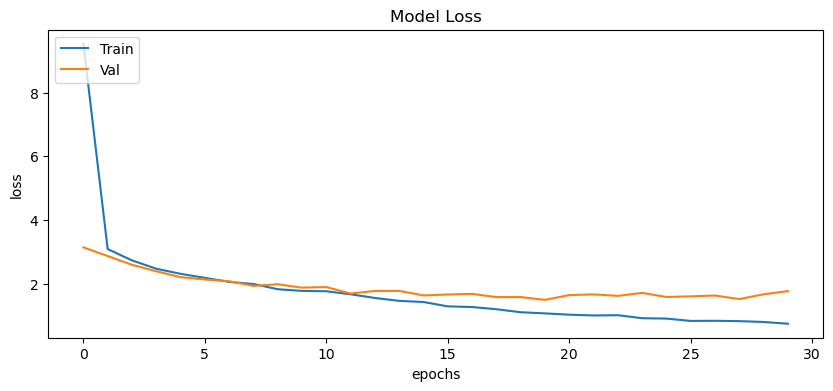

KeyError: 'accuracy'

<Figure size 1000x300 with 0 Axes>

KeyError: 'accuracy'

In [63]:
%run rueegg_wissiak_model_visualization.ipynb

In [64]:
model.evaluate(test_ds)

20/20 [==============================] - 2s 65ms/step - loss: 1.5848 - sparse_categorical_accuracy: 0.7883


[1.5847620964050293, 0.7883152961730957]

# Summary
This project as exciting as it was challenging. It made us really try out numerous ways on how to tweak both performance in the sense of speed and of model accuracy. It is interesting how a small change can have a huge impact on the model's learning behavior. We've also extensively dealt with the over- and underfitting effects which consolidated our understanding on how and when to use Regularization and Generalization optimizations. 

In summary, creating a model with tensorflow is very easy and convenient but creating a performant model can be an overwhelming and time consuming process that can be frustrating at some point. But seeing the results of a successful improvement, on the other hand, is very satisfactory.

## Outlook
As a wrap-up we'd like to give a short outlook on what could be further steps to improve the model or to take the model into production.

### Export and Reuse
Tensorflow allows to export the weights of a trained model. In this way a new model can be initialized using the saved weights and can be used directly to make predictions on unseen data. This would be the method we'd use if we'd take this model to some productive use. 